# Baseline RGB - ResNet18
## Beyond Visible Spectrum: AI for Agriculture 2026

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader
3. Model: ResNet18 pretrained
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 64,
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "model_name": "resnet18",
}

# Paths - LOCAL
TRAIN_RGB_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\train\RGB"
TEST_RGB_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\val\RGB"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"

# # Paths - KAGGLE
# TRAIN_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/train/RGB"
# TEST_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/test/RGB"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

Device: cpu


## 2. EDA - Exploratory Data Analysis

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


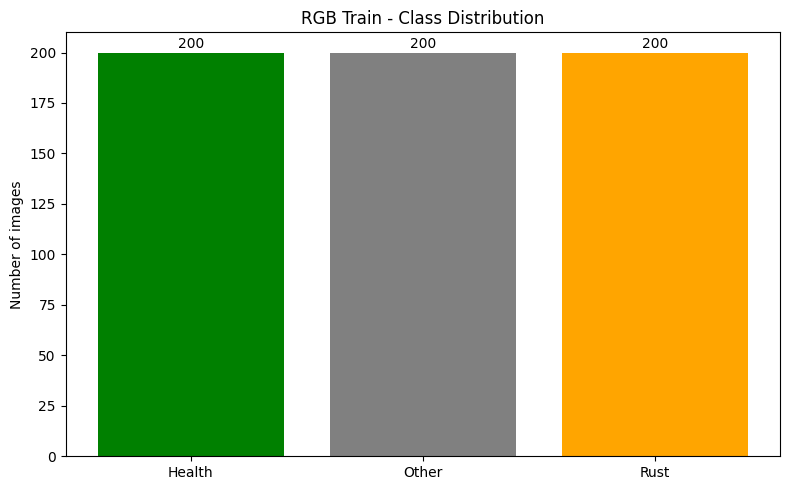

In [2]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.png' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('RGB Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

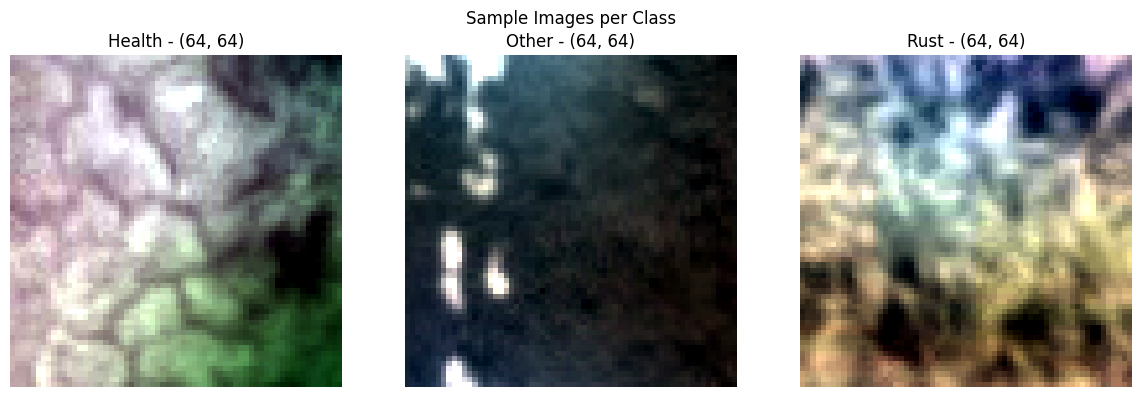

In [3]:
# Show sample images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, cls in enumerate(classes):
    sample_file = [f for f in files if label_from_filename(f) == cls][0]
    img = Image.open(os.path.join(TRAIN_RGB_DIR, sample_file))
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} - {img.size}")
    axes[i].axis('off')

plt.suptitle('Sample Images per Class')
plt.tight_layout()
plt.show()

## 3. Dataset & DataLoader

In [4]:
class RGBDataset(Dataset):
    """RGB Image Dataset - loads PNG images with labels from filename"""
    
    def __init__(self, img_dir, transform=None, file_list=None):
        self.img_dir = img_dir
        self.transform = transform
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class RGBTestDataset(Dataset):
    """RGB Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, fname

In [5]:
# Transforms
tfm_train = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tfm_val = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Split train/val
base_ds = RGBDataset(TRAIN_RGB_DIR, transform=None)
indices = np.arange(len(base_ds))
train_idx, val_idx = train_test_split(
    indices, 
    test_size=CONFIG["val_split"], 
    random_state=CONFIG["seed"], 
    stratify=base_ds.y
)

# Create datasets
train_files = [base_ds.files[i] for i in train_idx]
val_files = [base_ds.files[i] for i in val_idx]

train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train, file_list=train_files)
val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Classes: {train_ds.class_to_idx}")

# Verify shapes
x, y = next(iter(train_loader))
print(f"Batch shape: {x.shape}, Labels: {y[:5]}")

Train samples: 480
Val samples: 120
Classes: {'Health': 0, 'Other': 1, 'Rust': 2}
Batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([2, 2, 1, 1, 1])


## 4. Model Definition

In [6]:
def create_model(num_classes, pretrained=True):
    """Create ResNet18 model with custom FC layer"""
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Replace final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)

print(f"Model: {CONFIG['model_name']}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: resnet18
Parameters: 11,178,051


## 5. Training

In [7]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [8]:
# Initialize WandB
wandb.init(
    project="beyond-visible-spectrum",
    name=f"baseline_rgb_{CONFIG['model_name']}",
    config=CONFIG
)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Training loop
best_val_acc = 0.0
best_model_path = os.path.join(CHECKPOINT_DIR, "best_rgb_resnet18.pth")

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, CONFIG["epochs"] + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    # Scheduler step
    scheduler.step(val_acc)
    
    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "lr": optimizer.param_groups[0]['lr']
    })
    
    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

wandb.finish()
print(f"\n✓ Best val_acc: {best_val_acc:.4f}")
print(f"✓ Model saved to: {best_model_path}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\ADMIN\_netrc.
wandb: Currently logged in as: phucga150625 (phucga15062005) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01 | train_acc=0.4521 val_acc=0.5083 ⭐ BEST
Epoch 02 | train_acc=0.5979 val_acc=0.5750 ⭐ BEST
Epoch 03 | train_acc=0.5958 val_acc=0.5417
Epoch 04 | train_acc=0.6333 val_acc=0.5250
Epoch 05 | train_acc=0.6687 val_acc=0.4917
Epoch 06 | train_acc=0.6687 val_acc=0.5417
Epoch 07 | train_acc=0.6875 val_acc=0.5083
Epoch 08 | train_acc=0.7250 val_acc=0.5333
Epoch 09 | train_acc=0.7458 val_acc=0.5333
Epoch 10 | train_acc=0.7625 val_acc=0.5250


epoch,▁▂▃▃▄▅▆▆▇█
lr,█████▃▃▃▃▁
train_acc,▁▄▄▅▆▆▆▇██
train_loss,█▅▅▄▃▃▃▁▂▁
val_acc,▂█▅▄▁▅▂▅▅▄
val_loss,█▆▆▇▃▅▃▄▁▁
epoch,10
lr,3e-05
train_acc,0.7625
train_loss,0.54854
val_acc,0.525



✓ Best val_acc: 0.5750
✓ Model saved to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_rgb_resnet18.pth


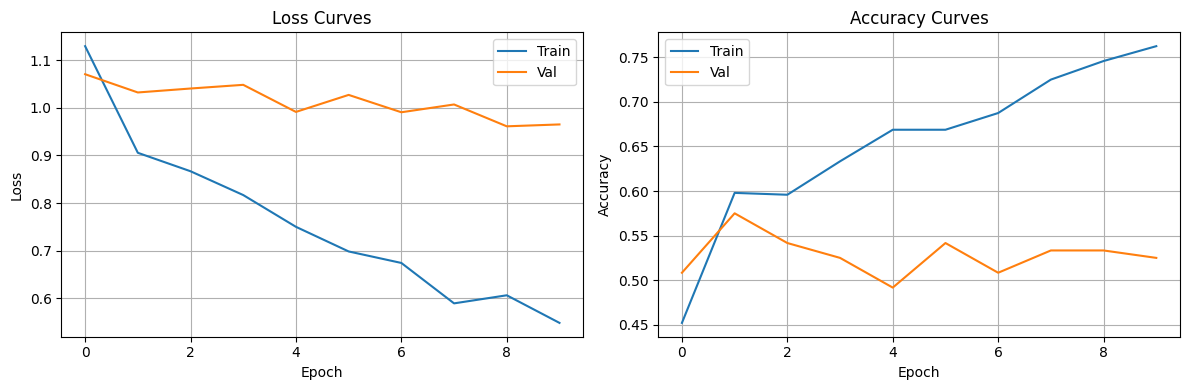

In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Val")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curves")
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history["train_acc"], label="Train")
axes[1].plot(history["val_acc"], label="Val")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curves")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Evaluation

In [10]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      Health       0.49      0.45      0.47        40
       Other       0.77      0.68      0.72        40
        Rust       0.50      0.60      0.55        40

    accuracy                           0.57       120
   macro avg       0.59      0.58      0.58       120
weighted avg       0.59      0.57      0.58       120



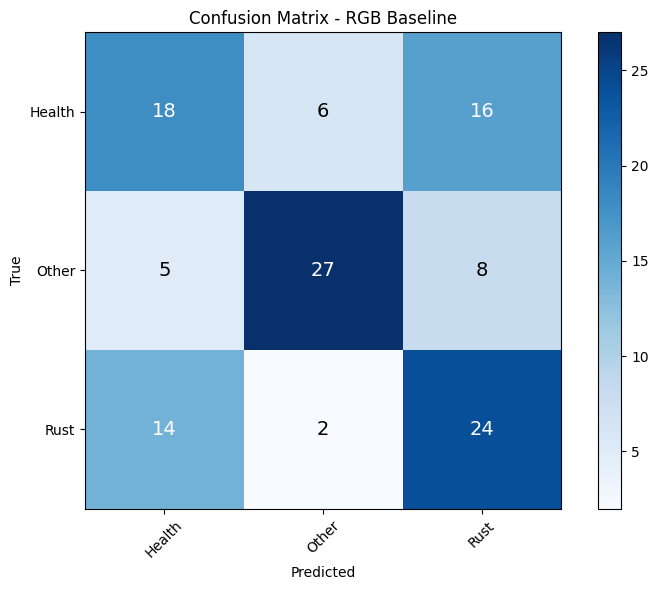

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RGB Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 7. Inference & Submission

In [12]:
# Check if test directory exists
if os.path.exists(TEST_RGB_DIR):
    # Create test dataset
    test_ds = RGBTestDataset(TEST_RGB_DIR, transform=tfm_val)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Test samples: {len(test_ds)}")
else:
    print(f"⚠️ Test directory not found: {TEST_RGB_DIR}")
    print("Skipping test inference...")

Test samples: 300


In [13]:
# Run inference on test set
if os.path.exists(TEST_RGB_DIR):
    model.eval()
    predictions = []
    filenames = []
    
    idx_to_class = val_ds.idx_to_class
    
    with torch.no_grad():
        for images, fnames in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # Convert to class names
            pred_labels = [idx_to_class[p] for p in preds]
            
            predictions.extend(pred_labels)
            filenames.extend(fnames)
    
    print(f"✓ Predicted {len(predictions)} test samples")
    print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

✓ Predicted 300 test samples
Sample predictions: [('val_000a83c1.png', 'Rust'), ('val_00a704b1.png', 'Rust'), ('val_01dde030.png', 'Other'), ('val_024df365.png', 'Health'), ('val_02afcb0e.png', 'Health')]


In [14]:
# import pandas as pd

# df = pd.read_csv(r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_task1_rgb.csv")

# label_map = {
#     "rust": "Rust",
#     "other": "Other",
#     "healthy": "Health"
# }

# df["label"] = df["label"].map(label_map)

# df.to_csv("submission_task1_rgb_FIXED.csv", index=False)
# print(df.head())


In [15]:
import os
import pandas as pd

if os.path.exists(TEST_RGB_DIR):
    submission_df = pd.DataFrame({
        "ID": filenames,      # TÊN CỘT ĐÚNG
        "label": predictions        # Rust / Other / Health
    })

    # sort cho đẹp (không bắt buộc nhưng nên làm)
    submission_df = submission_df.sort_values("ID").reset_index(drop=True)

    submission_path = os.path.join(CHECKPOINT_DIR, "submission_rgb.csv")
    submission_df.to_csv(submission_path, index=False)

    print(f"✓ Saved submission to: {submission_path}")
    print(f"✓ Total predictions: {len(submission_df)}")

    print("\nFirst 10 rows:")
    print(submission_df.head(10))

    print("\nLabel distribution:")
    print(submission_df["label"].value_counts())
else:
    print("⚠️ No test data - submission not created")


✓ Saved submission to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_rgb.csv
✓ Total predictions: 300

First 10 rows:
                 ID   label
0  val_000a83c1.png    Rust
1  val_00a704b1.png    Rust
2  val_01dde030.png   Other
3  val_024df365.png  Health
4  val_02afcb0e.png  Health
5  val_03864ba6.png    Rust
6  val_0537e324.png    Rust
7  val_059983e0.png    Rust
8  val_05cee914.png   Other
9  val_07af871a.png    Rust

Label distribution:
label
Rust      114
Other      95
Health     91
Name: count, dtype: int64


## 8. Overfitting Analysis (Optional)

In [16]:
# import pandas as pd

# # Giả sử submission_df là dataframe cũ của bạn
# submission_df = pd.DataFrame({
#     'Id': filenames,         # Đổi từ 'filename' sang 'Id'
#     'Category': formatted_labels  # Đổi từ 'label' sang 'Category' (kiểm tra lại tên cột này của BTC)
# })

# # Lưu file mới
# submission_df.to_csv('submission_task1_final.csv', index=False)

In [17]:
# Check for potential overfitting signs
print("=== Overfitting Analysis ===")
print(f"\nDataset size: {len(base_ds)} images")
print(f"Train/Val split: {len(train_ds)}/{len(val_ds)}")

# Gap between train and val accuracy
final_train_acc = history["train_acc"][-1]
final_val_acc = history["val_acc"][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Final Val Accuracy: {final_val_acc:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")

if gap > 0.1:
    print("⚠️ Large gap detected - possible overfitting!")
    print("   Suggestions: More augmentation, dropout, early stopping")
elif final_val_acc > 0.95:
    print("⚠️ Very high val_acc - check for data leakage!")
else:
    print("✓ Gap looks reasonable")

=== Overfitting Analysis ===

Dataset size: 600 images
Train/Val split: 480/120

Final Train Accuracy: 0.7625
Final Val Accuracy: 0.5250
Gap (Train - Val): 0.2375
⚠️ Large gap detected - possible overfitting!
   Suggestions: More augmentation, dropout, early stopping
